In [3]:
import pandas as pd
import pickle
import re
%pylab inline
import seaborn as sns

import os
sys.path.append(os.path.abspath("/Users/slueck/OneDrive - Axel Springer SE/Dokumente/pylibs/"))

from graph_temp import *

color = ['#e41a1c', '#377eb8'] 
colors4 = sns.color_palette('PuOr',4)
pd.set_option('mode.use_inf_as_na', True)

Populating the interactive namespace from numpy and matplotlib


### Load Data

In [4]:
dat = pd.read_pickle('PIV_angereichert_metrics')

In [5]:
dat.columns.values

array(['WT SSOID', 'VE Jahr/KW', 'Kuendigungsstatus', ...,
       'vPlusDesktop_per_v_zsc_usr_behav2',
       'vPlusDesktop_per_v_zsc_usr_behav3',
       'vPlusDesktop_per_v_zsc_usr_behav4'], dtype=object)

## Cluster-Bildung

### Nutzungsintensität

In [6]:
print('beide')
print(dat[['v_mean','v_sd_normed','pi_sd','pi_activ_wks','Vertragslaenge']].describe())
print('')
print('gekuendigt')
print(dat.loc[dat['Kuendigungsstatus']=='gekuendigt',['v_mean','v_sd_normed','pi_sd','pi_activ_wks','Vertragslaenge']].describe())
print('')
print('ungekuendigt')
print(dat.loc[dat['Kuendigungsstatus']=='ungekuendigt',['v_mean','v_sd_normed','pi_sd','pi_activ_wks','Vertragslaenge']].describe())

beide
            v_mean  v_sd_normed        pi_sd  pi_activ_wks  Vertragslaenge
count  7402.000000  6809.000000  6809.000000   7583.000000     8530.000000
mean     11.780182     0.494206    24.384888     16.860477        7.310551
std      12.438415     0.220903    26.677294      9.979763        5.156870
min       1.000000     0.000000     0.000000      0.000000        1.000000
25%       2.500000     0.349927     9.207962      6.000000        3.000000
50%       7.282857     0.473553    18.071164     21.000000        6.000000
75%      16.747685     0.618324    31.655599     27.000000       10.000000
max     103.703704     1.969869   786.549608     27.000000       63.000000

gekuendigt
            v_mean  v_sd_normed        pi_sd  pi_activ_wks  Vertragslaenge
count  1321.000000  1030.000000  1030.000000   1502.000000     2145.000000
mean      8.197017     0.483868    21.926685      5.726365        4.295571
std      10.546431     0.253236    39.008898      5.960929        3.478117
min    

##### Visits - mean

In [7]:
dat['v_userIntens_groups'] = '1low_Visits'
dat.loc[dat['v_mean']>=2.5 ,'v_userIntens_groups'] ='2medlow_visits' 
dat.loc[dat['v_mean']>=7.28 ,'v_userIntens_groups'] ='3medhigh_visits' 
dat.loc[dat['v_mean']>=16.7 ,'v_userIntens_groups'] ='4high_visits' 

##### Visits - volatility

In [8]:
dat['v_volatility_groups'] = '1low_variation_visits'
dat.loc[dat['v_sd_normed']>=0.35 ,'v_volatility_groups'] ='2medlow_variation_visits' 
dat.loc[dat['v_sd_normed']>=0.47 ,'v_volatility_groups'] ='3medhigh_variation_visits' 
dat.loc[dat['v_sd_normed']>=0.62 ,'v_volatility_groups'] ='4high_variation_visits' 

##### Active weeks

In [9]:
dat['active_time_groups'] = '1low_active_time'
dat.loc[dat['pi_activ_wks']>=6,'active_time_groups'] = '2medlow_active_time'
dat.loc[dat['pi_activ_wks']>=21,'active_time_groups'] = '3medhigh_active_time'
dat.loc[dat['pi_activ_wks']>=27,'active_time_groups'] = '4high_active_time'

##### Vertragslaenge

In [10]:
dat['vertragslaenge_groups'] = '1low_contractLength'
dat.loc[dat['pi_activ_wks']>=2,'vertragslaenge_groups'] = '2medlow_contractLength'
dat.loc[dat['pi_activ_wks']>=3,'vertragslaenge_groups'] = '3medhigh_contractLength'
dat.loc[dat['pi_activ_wks']>=5,'vertragslaenge_groups'] = '4high_contractLength'

### Data Set without Sleepers

In [11]:
sleeping1 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                  pd.isna(dat['pi_2018/17']) &
                  pd.isna(dat['pi_2018/18']) &
                  pd.isna(dat['pi_2018/19']) & 
                  pd.isna(dat['pi_2018/20']) &
                  pd.isna(dat['pi_2018/21'])]
sleeping2 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                  
                  pd.isna(dat['pi_2018/18']) &
                  pd.isna(dat['pi_2018/19']) & 
                  pd.isna(dat['pi_2018/20']) &
                  pd.isna(dat['pi_2018/21'])]
sleeping3 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                  pd.isna(dat['pi_2018/19']) & 
                  pd.isna(dat['pi_2018/20']) &
                  pd.isna(dat['pi_2018/21'])]
sleeping4 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                 
                  pd.isna(dat['pi_2018/20']) &
                  pd.isna(dat['pi_2018/21'])]
sleeping5 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                 pd.isna(dat['pi_2018/21'])]

print(sleeping1.shape)
print(sleeping2.shape)
print(sleeping3.shape)
print(sleeping4.shape)
print(sleeping5.shape)
print(dat.loc[dat['Kuendigungsstatus']=='ungekuendigt'].shape)

frames = [sleeping2, dat.loc[dat['Kuendigungsstatus']=='gekuendigt']]
dat_wo_sleeper = pd.concat(frames)


(1358, 1935)
(1501, 1935)
(1660, 1935)
(1915, 1935)
(2660, 1935)
(6385, 1935)


### Statistische Zwillinge finden

Statistische Zwilling in diesem Fall = Abschluss im gleichen Zeitraum, ähnliches Nutzer Verhalten (gleiche Gruppe userIntensity)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x10ac9c710>,
      dtype=object)

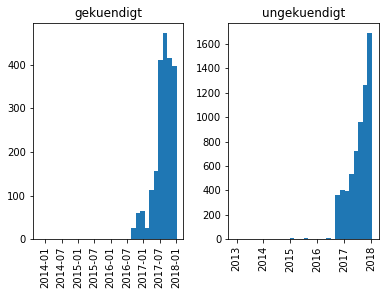

In [25]:
dat.hist(column='VB Tag',by = 'Kuendigungsstatus',bins=30)

In [12]:
df_medlow = dat.loc[(dat['v_userIntens_groups']=='2medlow_visits')&(dat['Vertragslaenge']>1)]
df_woSleep_medlow = dat_wo_sleeper.loc[(dat_wo_sleeper['v_userIntens_groups']=='2medlow_visits')&
                                       (dat_wo_sleeper['Vertragslaenge']>1)]

df_medhigh = dat.loc[dat['v_userIntens_groups']=='3medhigh_visits']
df_woSleep_medhigh = dat_wo_sleeper.loc[dat_wo_sleeper['v_userIntens_groups']=='3medhigh_visits']

df_woSleep = dat_wo_sleeper

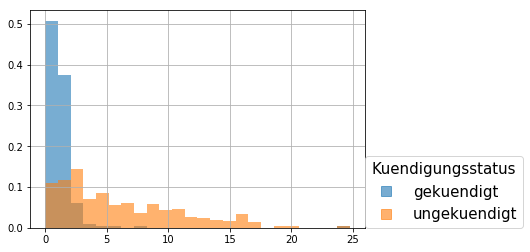

In [15]:
hist_factor(df_woSleep_medlow, column='pi_per_v_prz_usr_behav4',factor='Kuendigungsstatus',alpha=0.6,number_of_bins=25)

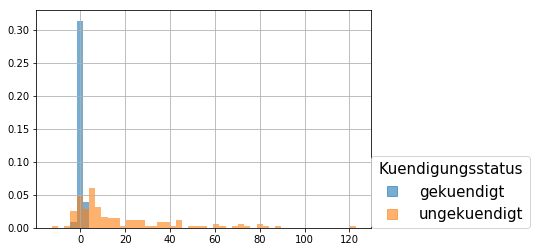

In [17]:
hist_factor(df_woSleep_medhigh, column='pi_per_v_zsc_usr_behav2',factor='Kuendigungsstatus',alpha=0.6,number_of_bins=50)

In [46]:
df_woSleep_medhigh.loc[df_woSleep_medhigh['pi_per_v_prz_usr_behav1']<2
                      ].groupby('Kuendigungsstatus').size()

Kuendigungsstatus
gekuendigt      166
ungekuendigt     32
dtype: int64

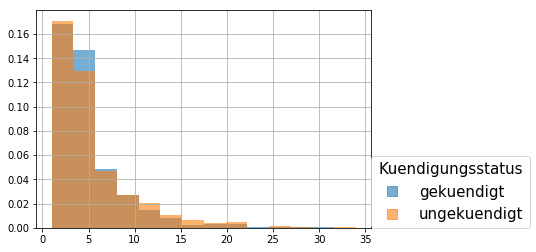

In [99]:
hist_factor(df_woSleep,column='pi_per_v_2017/47',factor='Kuendigungsstatus',alpha=0.6)

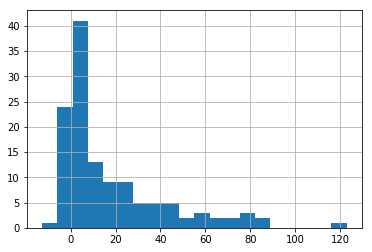

In [95]:
df_woSleep_medhigh.loc[df_woSleep_medhigh['Kuendigungsstatus']=='ungekuendigt','pi_per_v_zsc_usr_behav2'].hist(bins=20)

#### Nutzerverhalten Visits mean vs. votality

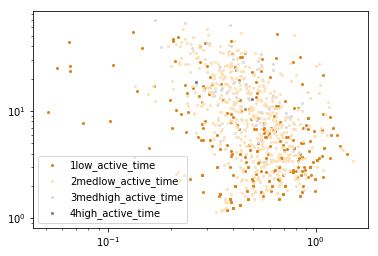

In [33]:
scatter_factor(dat.loc[dat['Kuendigungsstatus']=='gekuendigt'],'v_sd_normed','v_mean',
               factor='active_time_groups', alpha=1, logScale=True, colors=colors4)

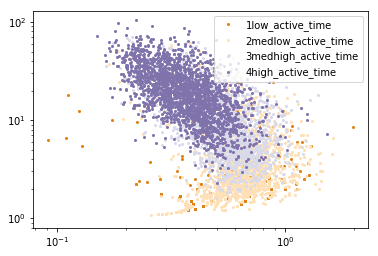

In [35]:
scatter_factor(dat.loc[dat['Kuendigungsstatus']=='ungekuendigt'],'v_sd_normed','v_mean',factor='active_time_groups', 
               alpha=1, logScale=True, colors=colors4)

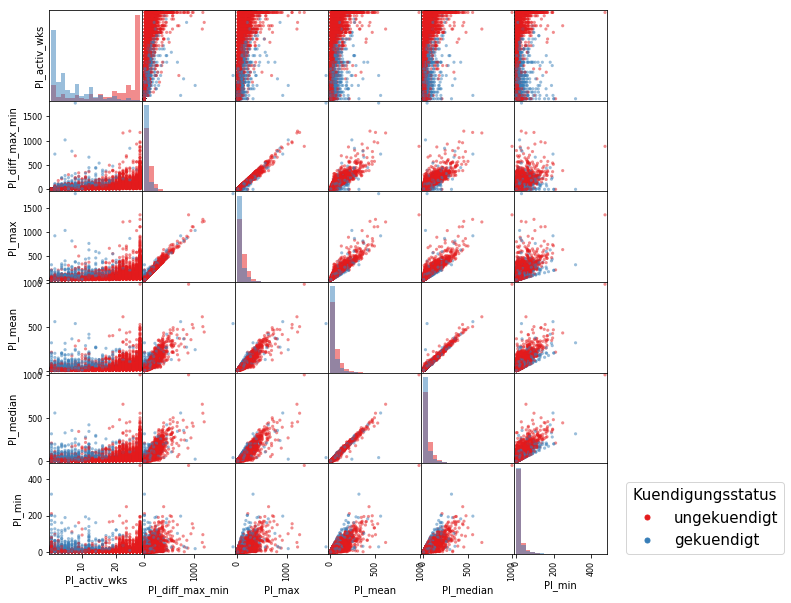

In [27]:
df = dat.loc[:,['PI_activ_wks', 'PI_diff_max_min', 'PI_max', 'PI_mean',
       'PI_median', 'PI_min','Kuendigungsstatus']]
df_wo_inf_nan = df.dropna()
axarr, color_map = factor_scatter_matrix(df_wo_inf_nan,'Kuendigungsstatus',hist='hist', normed=True, number_of_bins=20
                                )

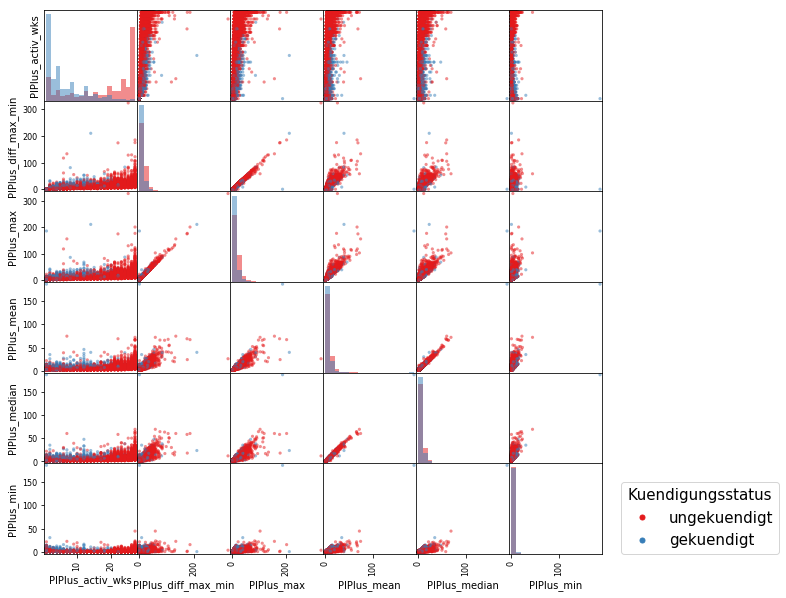

In [28]:
df = dat.loc[:,['PIPlus_activ_wks', 'PIPlus_diff_max_min', 'PIPlus_max', 'PIPlus_mean',
       'PIPlus_median', 'PIPlus_min','Kuendigungsstatus']]
df_wo_inf_nan = df.dropna()
axarr, color_map = factor_scatter_matrix(df_wo_inf_nan,'Kuendigungsstatus',hist='hist', normed=True, number_of_bins=20
                                )

In [ ]:
dat.groupby('Kuendigungsstatus')['PI_mean']

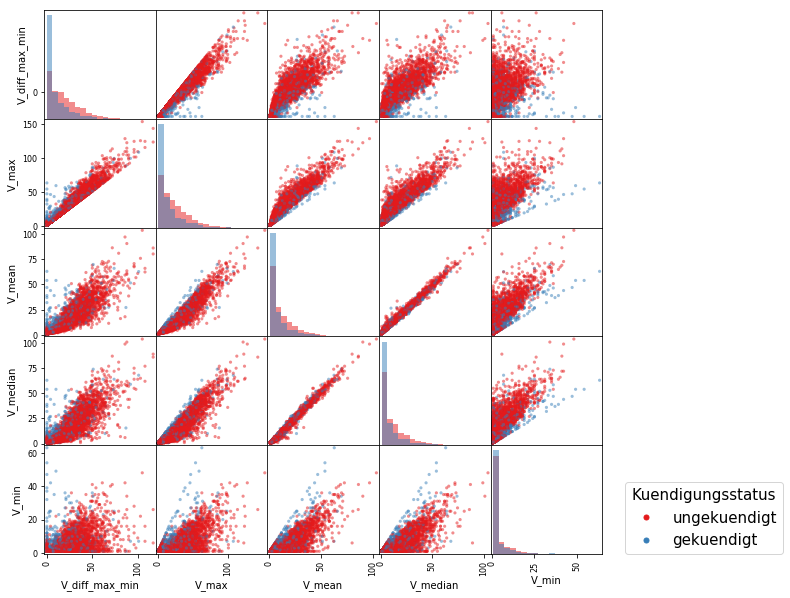

In [9]:
df = dat.loc[:,['V_diff_max_min', 'V_max', 'V_mean', 'V_median',
       'V_min','Kuendigungsstatus']]
df_wo_inf_nan = df.dropna()
axarr, color_map = factor_scatter_matrix(df_wo_inf_nan,'Kuendigungsstatus',hist='hist',normed=True,number_of_bins=20)

## Gekündigt vs. Schläfer

In [10]:
sleeping1 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                  pd.isna(dat['PI_2018/17']) &
                  pd.isna(dat['PI_2018/18']) &
                  pd.isna(dat['PI_2018/19']) & 
                  pd.isna(dat['PI_2018/20']) &
                  pd.isna(dat['PI_2018/21'])]
sleeping2 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                  
                  pd.isna(dat['PI_2018/18']) &
                  pd.isna(dat['PI_2018/19']) & 
                  pd.isna(dat['PI_2018/20']) &
                  pd.isna(dat['PI_2018/21'])]
sleeping3 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                  pd.isna(dat['PI_2018/19']) & 
                  pd.isna(dat['PI_2018/20']) &
                  pd.isna(dat['PI_2018/21'])]
sleeping4 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                 
                  pd.isna(dat['PI_2018/20']) &
                  pd.isna(dat['PI_2018/21'])]
sleeping5 = dat.loc[(dat['Kuendigungsstatus']=='ungekuendigt')&
                 pd.isna(dat['PI_2018/21'])]

In [10]:
print(sleeping1.shape)
print(sleeping2.shape)
print(sleeping3.shape)
print(sleeping4.shape)
print(sleeping5.shape)
print(dat.loc[dat['Kuendigungsstatus']=='ungekuendigt'].shape)


(1358, 415)
(1501, 415)
(1660, 415)
(1915, 415)
(2660, 415)
(6385, 415)


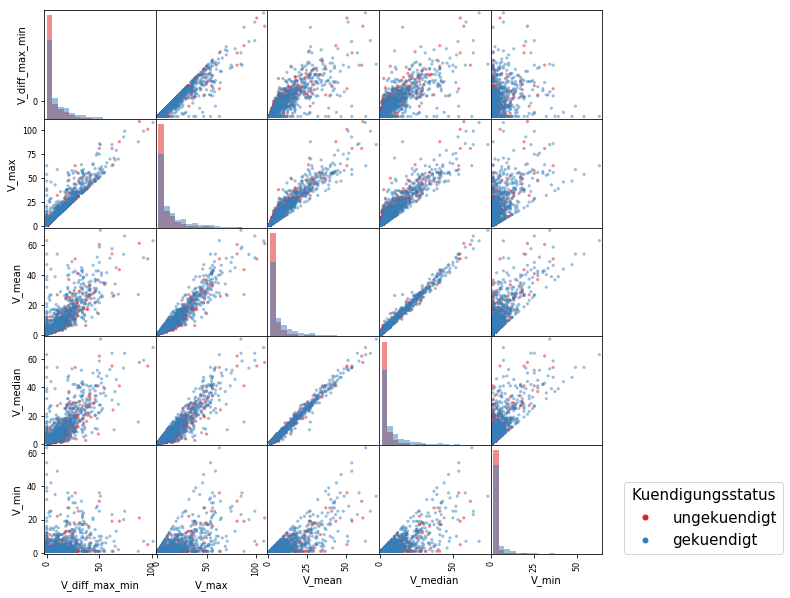

In [15]:
frames = [sleeping1, dat.loc[dat['Kuendigungsstatus']=='gekuendigt']]
dat_sleep_gekuendigt = pd.concat(frames)

df = dat_sleep_gekuendigt.loc[:,['V_diff_max_min', 'V_max', 'V_mean', 'V_median',
       'V_min','Kuendigungsstatus']]
df_wo_inf_nan = df.dropna()
axarr, color_map = factor_scatter_matrix(df_wo_inf_nan,'Kuendigungsstatus',hist='hist',normed=True, number_of_bins=20)

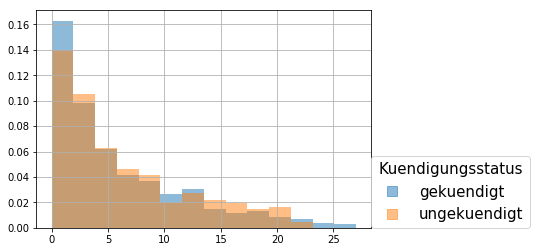

In [16]:
hist_factor(df=dat_sleep_gekuendigt, column='PI_activ_wks',factor='Kuendigungsstatus', alpha=0.5)

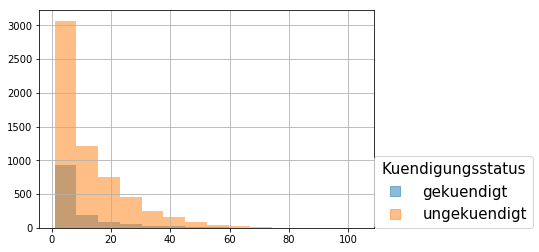

In [19]:
hist_factor(dat, column='V_mean',factor='Kuendigungsstatus', alpha=0.5, normed=False)

In [26]:
dat.groupby('Kuendigungsstatus')['_mean'].quantile(0.75)

Kuendigungsstatus
gekuendigt      44.00000
ungekuendigt    72.37037
Name: PI_mean, dtype: float64

#### Filtern = aktive Nutzer
Nur Nutzer, die mind. 5 Wochen das Abo genutzt haben. 

Nur Nutzer die mindestens einen Mittelwert von 10 Visists pro Woche haben.

In [36]:
dat_actwks6 = dat.loc[dat['PI_activ_wks']>12]
dat_Vmean10 = dat.loc[dat['V_mean']>5]
dat_PImean10 = dat.loc[dat['PI_mean']>40]

print((dat.groupby('Kuendigungsstatus').size())/dat.shape[0])
print(dat_actwks6.groupby('Kuendigungsstatus').size()/dat_actwks6.shape[0])
print(dat_Vmean10.groupby('Kuendigungsstatus').size()/dat_Vmean10.shape[0])
print(dat_PImean10.groupby('Kuendigungsstatus').size()/dat_PImean10.shape[0])



print(dat.groupby('Kuendigungsstatus').size())
print(dat_actwks6.groupby('Kuendigungsstatus').size())
print(dat_Vmean10.groupby('Kuendigungsstatus').size())

Kuendigungsstatus
gekuendigt      0.251465
ungekuendigt    0.748535
dtype: float64
Kuendigungsstatus
gekuendigt      0.040369
ungekuendigt    0.959631
dtype: float64
Kuendigungsstatus
gekuendigt      0.127529
ungekuendigt    0.872471
dtype: float64
Kuendigungsstatus
gekuendigt      0.115498
ungekuendigt    0.884502
dtype: float64
Kuendigungsstatus
gekuendigt      2145
ungekuendigt    6385
dtype: int64
Kuendigungsstatus
gekuendigt       197
ungekuendigt    4683
dtype: int64
Kuendigungsstatus
gekuendigt       561
ungekuendigt    3838
dtype: int64


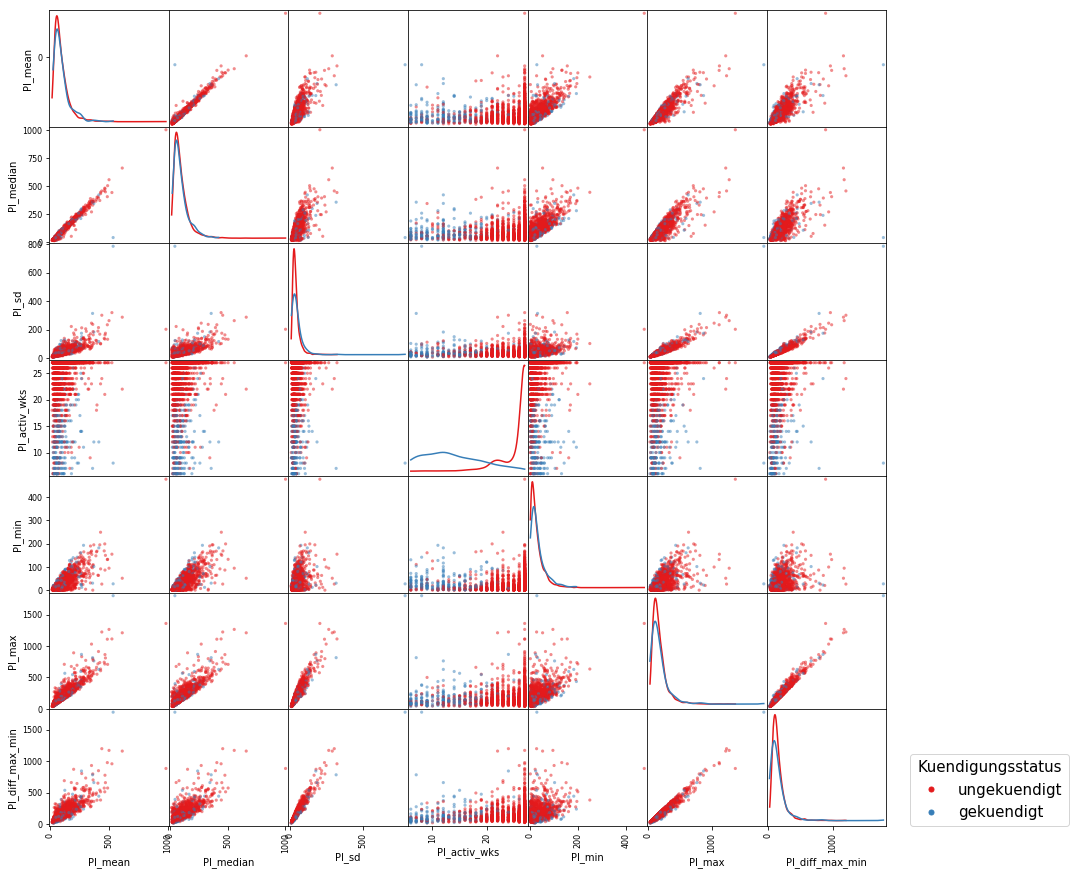

In [7]:
df = dat_Vmean10.loc[:,['PI_mean', 'PI_median',
       'PI_sd', 'PI_activ_wks', 'PI_min', 'PI_max','PI_diff_max_min','Kuendigungsstatus']]
df_wo_inf_nan = df.dropna()
axarr, color_map = factor_scatter_matrix(df_wo_inf_nan,'Kuendigungsstatus',figsize=15)


In [11]:
dat_Vmean10.loc[dat_Vmean10['Kuendigungsstatus']=='ungekuendigt'].head()

,WT SSOID,VE Jahr/KW,Kuendigungsstatus,Kuendigungsgrund,Promotion ID,Vertragsform,Trial Kennzeichen,Vertragsphase,VB Tag,VB Jahr,...,PISection_prz_usr_behav4,PISection_sd,PISection_usr_behav1,PISection_usr_behav2,PISection_usr_behav3,PISection_usr_behav4,PISection_zsc_usr_behav1,PISection_zsc_usr_behav2,PISection_zsc_usr_behav3,PISection_zsc_usr_behav4
WT SSOID,,,,,,,,,,,,,,,,,,,,,
ASAG1652928,ASAG1652928,2018/14,ungekuendigt,NaN,10003002,NOP,kostenloser Trial,Vollabo,2017-08-07,2017,...,0.250000,3.298346,10.0,10.0,20.0,1.0,1.532755,1.532755,4.564578,-1.195886
ASAG1666305,ASAG1666305,2018/11,ungekuendigt,NaN,10003002,NOP,kostenloser Trial,Vollabo,2017-04-16,2017,...,9.000000,2.214670,9.0,31.0,15.0,9.0,3.031732,12.965494,5.740940,3.031732
ASAG1668230,ASAG1668230,2018/12,ungekuendigt,NaN,10003002,NOP,kostenloser Trial,Vollabo,2017-06-21,2017,...,28.000000,NaN,33.0,27.0,30.0,28.0,NaN,NaN,NaN,NaN
ASAG1668634,ASAG1668634,2018/13,ungekuendigt,NaN,10003002,NOP,kostenloser Trial,Vollabo,2015-07-12,2015,...,4.666667,4.063829,23.0,26.0,28.0,14.0,4.545119,5.283340,5.775486,2.330459
ASAG1669840,ASAG1669840,2018/10,ungekuendigt,NaN,10003002,NOP,kostenloser Trial,Vollabo,2016-12-12,2016,...,27.000000,2.167948,27.0,30.0,29.0,27.0,11.439387,12.823184,12.361918,11.439387


In [10]:
dat_Vmean10.loc[dat_Vmean10['Kuendigungsstatus']=='gekuendigt'].groupby('PI_activ_wks').size()

PI_activ_wks
6.0     22
7.0     14
8.0     18
9.0     21
10.0     5
11.0    14
12.0    39
13.0    10
14.0    14
15.0    13
16.0    14
17.0    11
18.0    10
19.0    15
20.0     7
21.0     6
22.0     6
23.0     5
24.0     5
25.0     3
26.0     6
27.0     2
dtype: int64